In [1]:
# -*- coding: utf-8 -*-
import os
import glob 
import pandas as pd
import string
import collections
from tqdm import tqdm
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import DataLoader
import torch.optim as optim
from Gen.chinese_data import common_chinese_chars
from crnn import CaptchaDataset, BCRNN, QCRNN, Engine, calculate_loss
from utils import binarize_weights, quantify_weights
from bnn_layer import BLinear, BConv2d, HLinear, BLSTM, BLSTMCell

char_num:311


In [2]:
path = r'.\\data\\chinese\\new_data'
labels_file = f'{path}\\labels.txt'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [3]:
all_letters = common_chinese_chars
mapping = {}
mapping_inv = {}
i = 1
for x in all_letters:
    mapping[x] = i
    mapping_inv[i] = x
    i += 1
num_class = len(mapping)

In [4]:
images = []
labels = []
datas = collections.defaultdict(list)
data_len = 0
with open(labels_file, 'r', encoding='utf-8') as f:
    for line in f:
        line = line.strip()
        image_name, chinese_text = line.split(',')
        chinese_chars = list(chinese_text)
        datas['image'].append(image_name)
        datas['label'].append([mapping[i] for i in chinese_chars])
        data_len += 1
df = pd.DataFrame(datas)
df_train, df_test = train_test_split(df, test_size=0.2, shuffle=True)
transform = T.Compose([T.ToTensor()])
train_data = CaptchaDataset(df_train, transform, path)
test_data = CaptchaDataset(df_test, transform, path)
train_loader = DataLoader(train_data, batch_size=20, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10)

In [5]:
model = BCRNN(in_channels=1, output=num_class, print_val=True).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CTCLoss()

engine = Engine(model, optimizer, criterion, device=DEVICE)
mapping, mapping_inv = engine.load_model('./model/BNN_B_small.pth')
model.eval()

BCRNN(
  (conv1): BConv2d(
    (conv): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): BConv2d(
    (conv): Conv2d(4, 32, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (pool2): MaxPool2d(kernel_size=(4, 2), stride=(4, 2), padding=0, dilation=1, ceil_mode=False)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): BConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (pool3): MaxPool2d(kernel_size=(3, 2), stride=(3, 2), padding=0, dilation=1, ceil_mode=False)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): BConv2d(
    (conv): Conv2d(64, 128, kernel_size=(3, 4), stride=(1, 1), padding=(1, 1), bias=False)

In [6]:
test_loss = calculate_loss(test_loader, model, criterion, DEVICE)
print(f'Average Test Loss: {test_loss:.4f}')

Average Test Loss: 0.1116


In [7]:
binarize_weights(model)
# quantify_weights(model)

In [8]:
for name, module in model.named_modules():
    if isinstance(module, (torch.nn.BatchNorm2d, torch.nn.BatchNorm1d)):
        # 如果当前模块是Batch Normalization层
        mean = module.running_mean.cpu().detach().numpy().flatten()
        var = module.running_var.cpu().detach().numpy().flatten()
        std = np.sqrt(var + 10**(-5))
        print(f"Layer: {name} | Mean : {mean[0]} | var : {var[0]} | std : {std[0]} \n")
for name, param in model.named_parameters():
    # if any(name.startswith(layer) for layer in ["linear2"]):
    print(f"Layer: {name} | Size: {param.size()} | Value: {param} | Type : {param.dtype}\n" )


Layer: bn1 | Mean : -3.5145862102508545 | var : 4.2829084396362305 | std : 2.069521427154541 

Layer: bn2 | Mean : 11.094236373901367 | var : 85.657958984375 | std : 9.255159378051758 

Layer: bn3 | Mean : 25.212255477905273 | var : 536.6034545898438 | std : 23.164703369140625 

Layer: bn4 | Mean : 38.185333251953125 | var : 1318.4853515625 | std : 36.31095504760742 

Layer: bn6 | Mean : -0.4155735671520233 | var : 0.16016548871994019 | std : 0.40021929144859314 

Layer: conv1.conv.weight | Size: torch.Size([4, 1, 3, 3]) | Value: Parameter containing:
tensor([[[[ 1., -1., -1.],
          [-1., -1., -1.],
          [ 1., -1., -1.]]],


        [[[-1., -1.,  1.],
          [-1., -1., -1.],
          [ 1.,  1., -1.]]],


        [[[ 1.,  1., -1.],
          [-1., -1., -1.],
          [-1., -1.,  1.]]],


        [[[ 1.,  1., -1.],
          [ 1.,  1., -1.],
          [-1.,  1., -1.]]]], device='cuda:0', requires_grad=True) | Type : torch.float32

Layer: bn1.weight | Size: torch.Size([4]) 

In [9]:
test_loss = calculate_loss(test_loader, model, criterion, DEVICE)
print(f'Average Test Loss: {test_loss:.4f}')

Average Test Loss: 0.1116


In [10]:
import numpy as np
import torch
from utils import save_weights_to_h_file
output_path = 'model_weights.h'

# 调用函数保存权重
save_weights_to_h_file(model, output_path)
print(f'Weights saved to {output_path}')


B_Clayers conv1.conv.weight
9
F_layers bn1.weight
F_layers bn1.bias
B_Clayers conv2.conv.weight
64
F_layers bn2.weight
F_layers bn2.bias
B_Clayers conv3.conv.weight
288
F_layers bn3.weight
F_layers bn3.bias
B_Clayers conv4.conv.weight
768
F_layers bn4.weight
F_layers bn4.bias
B_layers linear1.linear.weight
B_layers rnn.layers_f.0.W_ih
B_layers rnn.layers_f.0.W_hh
B_layers rnn.layers_r.0.W_ih
B_layers rnn.layers_r.0.W_hh
F_layers bn6.weight
F_layers bn6.bias
F_layers linear2.linear.weight
bn1
bn2
bn3
bn4
bn6
Weights saved to model_weights.h


Prediction: 社会的发展


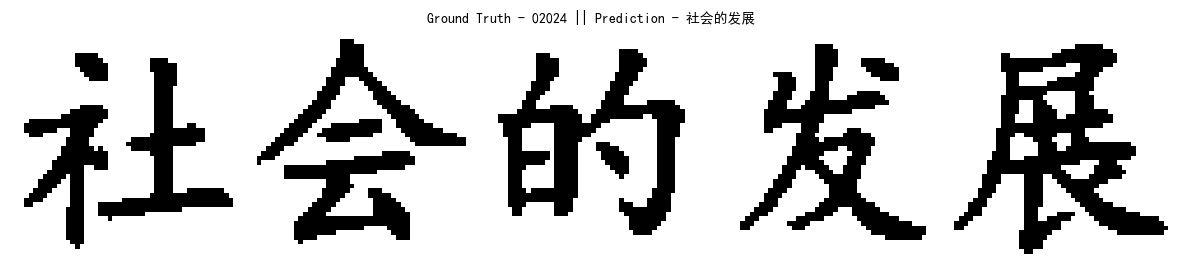

[ 0  8  0  0  9  0  0  1  0  0 10  0  0 11 11]


In [11]:
image_path = '.\\data\\chinese\\new_data\\02024.png'  # 替换为实际验证码图片路径
out = engine.predict(image_path)[0]

# 解析预测结果
def decode_prediction(out, mapping_inv):
    pred = ''
    then = -1
    for x in out:
        if then != x:
            if x > 0 :
                pred += mapping_inv[x]
        then = x
    return pred

# 显示预测结果
prediction = decode_prediction(out, mapping_inv)
print(f'Prediction: {prediction}')
font_path = ".\\Gen\\font\\SimHei.ttf"  # 替换成你的中文字体文件路径
myfont = FontProperties(fname=font_path)
def show_prediction(out, image_path, mapping_inv):
    gt = image_path.split('\\')[-1].split('.')[0]
    imagePIL = Image.open(image_path).convert('L')
    pred = decode_prediction(out, mapping_inv)

    plt.figure(figsize=(15, 12))
    img_array = np.asarray(imagePIL)
    plt.title(f'Ground Truth - {gt} || Prediction - {pred}', fontproperties=myfont)
    plt.axis('off')
    plt.imshow(img_array, cmap='gray')
    plt.show()
show_prediction(out, image_path, mapping_inv)
print(out)

In [12]:
from utils import save_data_to_h_file

output_path = './data/test_chinese_data.h'
imagePIL = np.asarray(Image.open(image_path).convert('L'))
save_data_to_h_file(imagePIL, output_path)
# print(imagePIL)

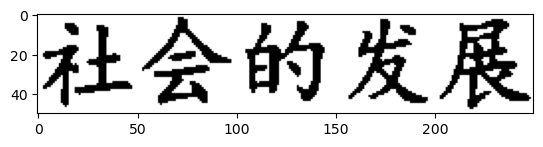

In [13]:
pic = imagePIL.reshape(50,250)
plt.imshow(pic, cmap='gray')
plt.show()